In [1]:
import torch, pickle, argparse
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from old_S2CNN_model import S2ConvNet
from data_loader import load_train_data, load_test_data
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfFastGradientAttack
from tqdm.notebook import tqdm
from attack_helper import run_batched_attack, run_batched_attack_cpu, batched_accuracy

In [2]:
total = 10000
bs=10

In [3]:
filename = 'S2CNN_first_tests_smaller_training_sets.pickle'

with open(filename, 'rb') as file:
    loaded = pickle.load(file)
    
data = np.array(loaded)
hparams = argparse.Namespace(**data[1][1][1])


TEST_PATH = "s2_mnist.gz"
TRAIN_PATH = "s2_mnist_train_dwr_10000.gz"

train_data = load_train_data(TRAIN_PATH)
test_data = load_test_data(TEST_PATH)

images = test_data[:total][0]
labels = test_data[:total][1]


model = S2ConvNet(hparams, train_data, test_data).eval()
trainer = pl.Trainer(gpus=1, logger=False)
best_model = torch.load('checkpoints/epoch=17_v14.ckpt')
model.load_state_dict(best_model['state_dict'])

fmodel = PyTorchModel(model, bounds=(0, 255))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [4]:
attack = LinfFastGradientAttack(random_start=False)
epsilons = [0.1, 0.5, 1, 5, 10, 20, 30, 50, 80, 100]

raw_advs_cpu, clipped_advs_cpu, success_cpu = run_batched_attack_cpu(attack, fmodel, images, labels, epsilons, bs)
clean_accuracy = batched_accuracy(fmodel, images, labels, bs)

  0%|          | 0/1000 [00:00<?, ?it/s]

load 0.pkl.gz... done
load 0.pkl.gz... done
load 0.pkl.gz... done
load 1.pkl.gz... done
load 0.pkl.gz... done
load 2.pkl.gz... done
load 3.pkl.gz... done
load 1.pkl.gz... done
load 4.pkl.gz... done
load 2.pkl.gz... done
load 5.pkl.gz... done
load 6.pkl.gz... done
load 3.pkl.gz... done
load 7.pkl.gz... done
load 4.pkl.gz... done
load 8.pkl.gz... done
load 9.pkl.gz... done
load 5.pkl.gz... done
load 10.pkl.gz... done


  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
success_rate = ep.astensor(success_cpu).float32().mean(axis=-1).raw.cpu()

robust_accuracy = 1 - success_rate
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

robust accuracy for perturbations with
  Linf norm ≤ 0.1   : 97.6 %
  Linf norm ≤ 0.5   : 96.6 %
  Linf norm ≤ 1     : 95.4 %
  Linf norm ≤ 5     : 68.0 %
  Linf norm ≤ 10    : 30.2 %
  Linf norm ≤ 20    : 11.4 %
  Linf norm ≤ 30    :  6.5 %
  Linf norm ≤ 50    :  2.2 %
  Linf norm ≤ 80    :  1.2 %
  Linf norm ≤ 100   :  1.9 %


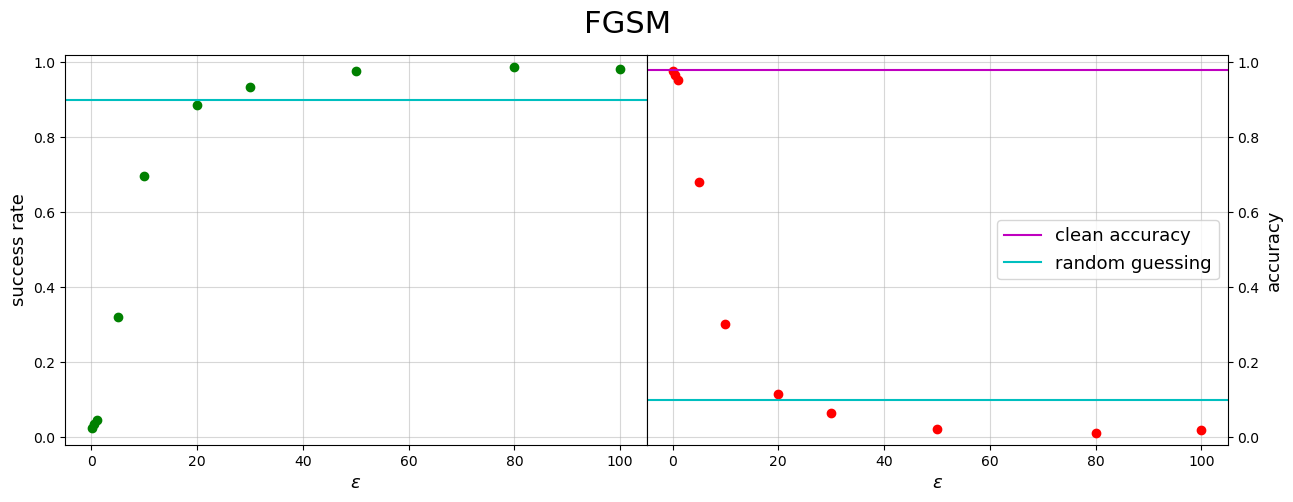

In [6]:
fontsize = 13

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15, 5), gridspec_kw = {'wspace':0., 'hspace':0.})
fig.suptitle('FGSM', fontsize=22)
plt.subplots_adjust(top=0.89)
axs[0].plot(epsilons, success_rate, 'og')
axs[0].set_ylabel('success rate', fontsize=fontsize)
axs[0].axhline(y=0.9, color='c')
axs[1].plot(epsilons, robust_accuracy, 'or')
# axs[1].plot(epsilons, post_acc, 'ob')
axs[1].axhline(y=clean_accuracy, color='m', label='clean accuracy')
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylabel('accuracy', fontsize=fontsize)
axs[1].axhline(y=0.1, color='c', label='random guessing')
for j in range(2):
    axs[j].set_xlabel(r'$\epsilon$', fontsize=fontsize)
    axs[j].set_ylim([-0.02,1.02])
    axs[j].grid(alpha=0.5)

axs[1].legend(fontsize=fontsize)

plt.show()